In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from astropy.io import fits
%matplotlib widget

In [2]:
science_list = np.genfromtxt('../group08_HAT-P-12_20230214/science/science_list', dtype=str)
print(science_list)

['AF823353.fits' 'AF823354.fits' 'AF823355.fits' 'AF823356.fits'
 'AF823357.fits' 'AF823358.fits' 'AF823359.fits' 'AF823360.fits'
 'AF823361.fits' 'AF823362.fits' 'AF823363.fits' 'AF823364.fits'
 'AF823365.fits' 'AF823366.fits' 'AF823367.fits' 'AF823368.fits'
 'AF823369.fits' 'AF823370.fits' 'AF823371.fits' 'AF823372.fits'
 'AF823373.fits' 'AF823374.fits' 'AF823375.fits' 'AF823376.fits'
 'AF823377.fits' 'AF823378.fits' 'AF823379.fits' 'AF823380.fits'
 'AF823381.fits' 'AF823382.fits' 'AF823383.fits' 'AF823384.fits'
 'AF823385.fits' 'AF823386.fits' 'AF823387.fits' 'AF823388.fits'
 'AF823389.fits' 'AF823390.fits' 'AF823391.fits' 'AF823392.fits'
 'AF823393.fits' 'AF823394.fits' 'AF823395.fits' 'AF823396.fits'
 'AF823397.fits' 'AF823398.fits' 'AF823399.fits' 'AF823400.fits'
 'AF823401.fits' 'AF823402.fits' 'AF823403.fits' 'AF823404.fits'
 'AF823405.fits' 'AF823406.fits' 'AF823407.fits' 'AF823408.fits'
 'AF823409.fits' 'AF823410.fits' 'AF823411.fits' 'AF823412.fits'
 'AF823413.fits' 'AF82341

We will perform data analysis in a small sample of the frames to simulate a large dataset or heavy ones from big space missions (e.g. Kepler, OMEGACAM, PLATO)

In [3]:
science_test_list = science_list[:10]

In [4]:
median_bias = pickle.load(open('../Results/median_bias.p', 'rb'))
median_bias_error = pickle.load(open('../Results/median_bias_error.p', 'rb'))

median_norm_flat = pickle.load(open('../Results/median_normalized_flat.p', 'rb'))
median_norm_flat_error = pickle.load(open('../Results/median_normalized_flat_error.p', 'rb'))

In [5]:
dir_name = '../group08_HAT-P-12_20230214/correct/'

for science_name in science_test_list:
    science_fits = fits.open('../group08_HAT-P-12_20230214/science/' + science_name)
    science_data = science_fits[0].data * science_fits[0].header['GAIN']
    science_fits.close()

    science_debiased = science_data - median_bias
    science_corrected = science_debiased / median_norm_flat

    #associated errors
    science_debiased_error = np.sqrt(science_fits[0].header['RDNOISE']**2 + science_debiased + median_bias_error**2)
    science_corrected_error = science_debiased * np.sqrt((science_debiased_error/science_debiased)**2 + (median_norm_flat/median_norm_flat_error)**2)
    
    #in the final code we must include [added 11/11]
    #centroid determination
    #JD to BJD conversion
    #aperture photometry

    pickle.dump(science_corrected, open(dir_name + science_name[:-5] + '.p', 'wb'))  #the [:-5] is to remove the .fits
    pickle.dump(science_corrected_error, open(dir_name + science_name[:-5] + '_err.p', 'wb'))

/tmp/ipykernel_1021/2579387393.py:9: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_norm_flat
/tmp/ipykernel_1021/2579387393.py:9: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_norm_flat
/tmp/ipykernel_1021/2579387393.py:13: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_debiased * np.sqrt((science_debiased_error/science_debiased)**2 + (median_norm_flat/median_norm_flat_error)**2)
/tmp/ipykernel_1021/2579387393.py:13: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error = science_debiased * np.sqrt((science_debiased_error/science_debiased)**2 + (median_norm_flat/median_norm_flat_error)**2)


Warning $\neq$ Error

An error stops the code while a Warning performs the calculations but warns (eheh) that something may be wrong. So it is better to investigate if you do not expect the Warning.

### 06/11

Added the $\texttt{correct}$ directory to store the corrected science frames (see cell [11]).

In [6]:
n_images = len(science_test_list)

array_jd = np.zeros(n_images)
array_exptime = np.zeros(n_images)
array_airmass = np.zeros(n_images)

for i_science, science_name in enumerate(science_test_list):
    science_fits = fits.open('../group08_HAT-P-12_20230214/science/' + science_name)
    array_jd[i_science] = science_fits[0].header['JD']
    array_exptime[i_science] = science_fits[0].header['EXPTIME']
    array_airmass[i_science] = science_fits[0].header['AIRMASS']
    science_fits.close()

print(array_exptime)    #exposure time in sec

[12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]


### 11/11

Our data are in JD_UTC. We therefore have to convert to BJD_TDB. Moreover, the time in the header is referred to the beginning of the exposure, we must evaluate the central time of the exposure otherwise the plot will be shifted by half of the exposure.

In [7]:
array_midexp = array_jd + array_exptime/2/86400
array_midexp

array([2459990.56254544, 2459990.56270644, 2459990.56286644,
       2459990.56302744, 2459990.56318844, 2459990.56334944,
       2459990.56351044, 2459990.56367044, 2459990.56383144,
       2459990.56399244])

In [8]:
from astropy.time import Time
from astropy import coordinates as coord
from astropy import units as u

In [9]:
head = fits.open('../group08_HAT-P-12_20230214/science/' + science_list[0])
RA, DEC = head[0].header['OBJCTRA'], head[0].header['OBJCTDEC']
print(RA, DEC)

13:57:33.25 +43:29:35


In [10]:
target = coord.SkyCoord(RA, DEC, unit=(u.hourangle, u.deg), frame='icrs')
telescope = coord.SkyCoord(head[0].header['RA'], head[0].header['DEC'], unit=(u.hourangle, u.deg), frame='icrs')

telescope.ra.deg - target.ra.deg

-0.04929166666667584

In [11]:
#modified jd (mjd) = jd - 2400000.5 [the 0.5 shifts the begin of the day to noon]

time_object = Time(array_midexp, format='jd', scale='utc', location=('45.8472d', '11.569d'))    #coords of the telescope from the website

In [12]:
bjd_tdb = time_object.tdb + time_object.light_travel_time(target, ephemeris='jpl')

In [13]:
print((bjd_tdb.value - array_midexp)*86400)
#about 5 minute difference

[315.02110362 315.02166688 315.02223015 315.02279341 315.02335668
 315.02391994 315.0244832  315.02504647 315.02560973 315.026173  ]


In [14]:
jd_plot = np.arange(2600000., 2600365.25, 0.01)
time_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d'))
ltt_target_plot = time_plot.light_travel_time(target, ephemeris='jpl')
ltt_telescope_plot = time_plot.light_travel_time(telescope, ephemeris='jpl')

/home/michele/miniforge3/envs/astrolab2/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 36525 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/michele/miniforge3/envs/astrolab2/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 36525 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/michele/miniforge3/envs/astrolab2/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 36525 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


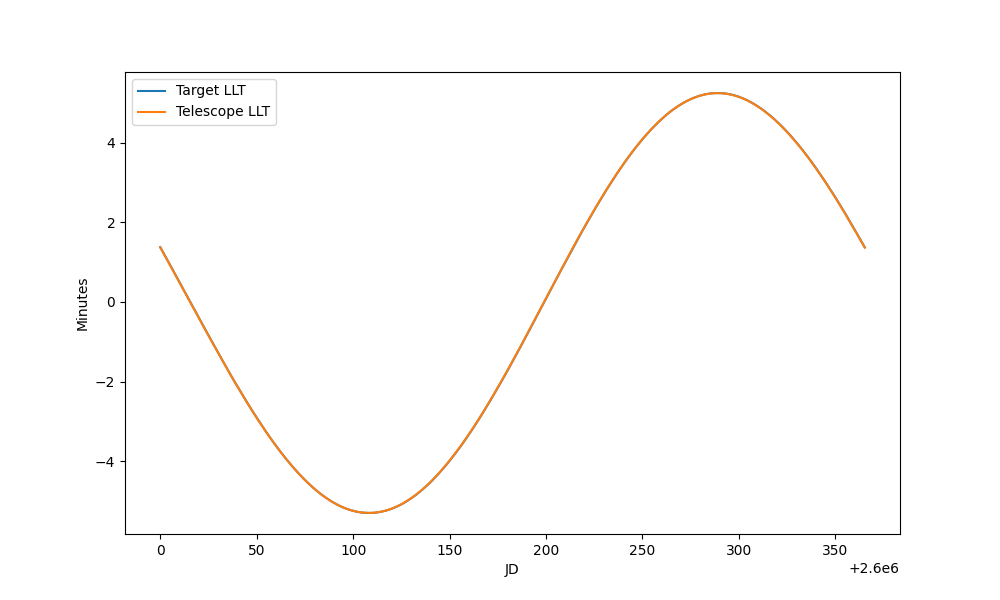

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(jd_plot, ltt_target_plot.to_value(u.min), label='Target LLT')
plt.plot(jd_plot, ltt_telescope_plot.to_value(u.min), label='Telescope LLT')
plt.legend(loc='best')
plt.xlabel('JD')
plt.ylabel('Minutes')
plt.show()

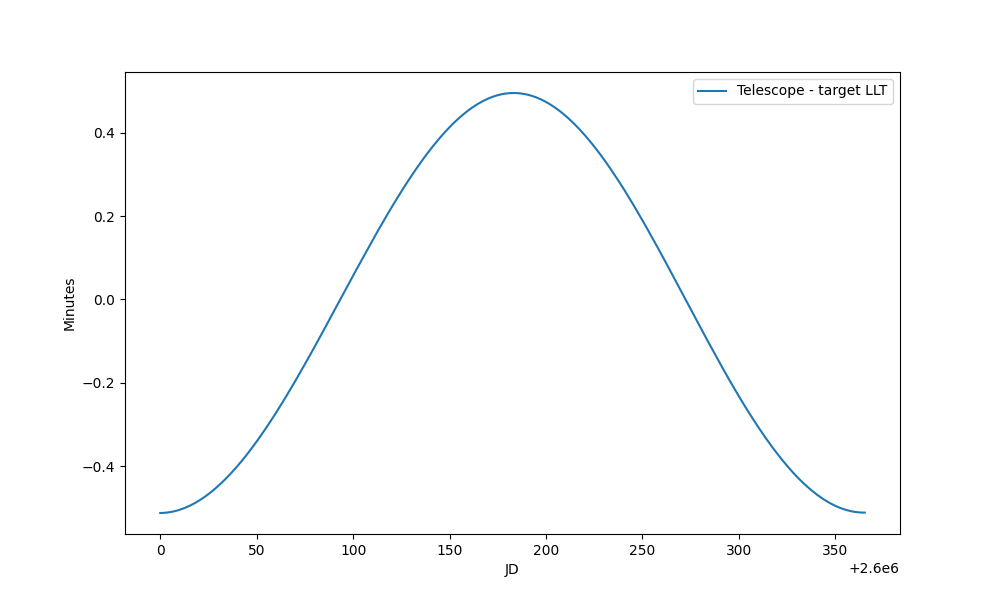

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(jd_plot, ltt_telescope_plot.to_value(u.s) - ltt_target_plot.to_value(u.s), label='Telescope - target LLT')
plt.legend(loc='best')
plt.xlabel('JD')
plt.ylabel('Minutes')
plt.show()

vmin: 943.26 vmax: 27693.40


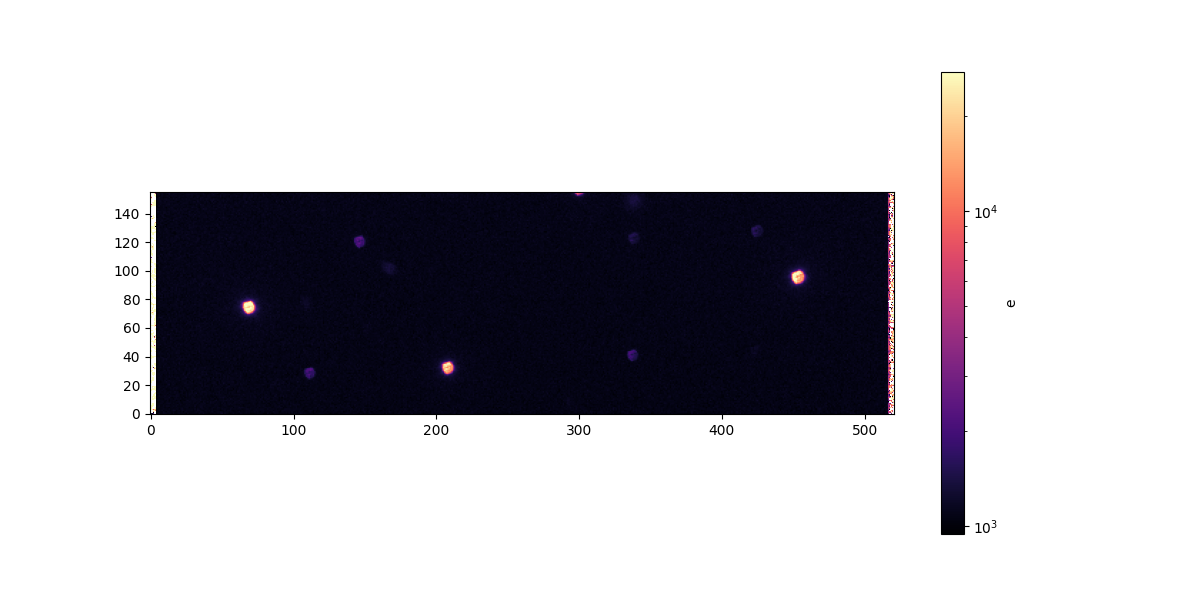

In [17]:
science_frame_name = '../group08_HAT-P-12_20230214/correct/' + science_test_list[-1][:-5] + '.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

import matplotlib.colors as colors

vmin = np.amin(science_corrected[:, 100:400])
vmax = np.amax(science_corrected[:, 100:400])
print('vmin: {0:5.2f} vmax: {1:5.2f}'.format(vmin, vmax))

fig = plt.figure(figsize=(12, 6))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
cbar = fig.colorbar(im1)

cbar.set_label('e')
plt.show()

In [18]:
head[0].header['ROTANGLE']

#now we have to find out which one is the target and which one is the reference

70.0